<a href="https://colab.research.google.com/github/drscook/m5364_23sp_data_science1/blob/main/pipelines_AirBNB_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup & Background

In [1]:
# upgrade to most recent versions (Pandas 2.0 released on April 6, 2023)
# run once at start of session
# ignore any "pip dependency" errors
! pip install -q --upgrade numpy pandas scikit-learn matplotlib shap jupyter-autotime
# restart kernel so upgrade takes effect
from IPython import get_ipython
get_ipython().kernel.do_shutdown(True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 63.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 2.0.1 which is incompatible.


{'status': 'ok', 'restart': True}

#Preprocessing

In [1]:
%reload_ext autotime
import os, pathlib, joblib, contextlib, google.colab, missingno as msno
import numpy as np, pandas as pd, sklearn, shap, matplotlib.pyplot as plt, seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay

sklearn.set_config(transform_output = "pandas")
def disp(X):
    display(pd.DataFrame(X).head(3))

# set random seed for reproducible results
seed = 42

# mount drive and set path
root = pathlib.Path("/content/drive")
google.colab.drive.mount(str(root))
path = root / "MyDrive/CEE_workshop"
path.mkdir(exist_ok=True)

# read or fetch data
file = path / "airbnb.parquet"
try:
    df = pd.read_parquet(file)
    print(f'using data saved at {file}')
except:
    print(f'downloading data')
    airbnb = fetch_openml(data_id=43819, parser="auto")
    df = airbnb.data
    print(f'saving data to {file}')
    df.to_parquet(file, index=False)
df = df.convert_dtypes().set_index('id')

for col in df.columns:
    try:
        df[col] = df[col].str.lower()
    except AttributeError:
        pass
df['price'] = df['price'].str.replace(',','').astype(float)
df['pets_ok'] = ~df['house_rules'].str.contains('no pets')
df['smoking_ok'] = ~df['house_rules'].str.contains('smok')

target = 'review_scores_rating'
features         = ['price', 'bedrooms', 'bathrooms', 'cleaning_fee', 'pets_ok', 'smoking_ok', 'amenities_dict', 'neighbourhood_cleansed']
numeric_features = ['price', 'bedrooms', 'bathrooms', 'cleaning_fee', 'pets_ok', 'smoking_ok']
mask = df[target].notnull()
F = df.loc[mask, features]

A = df['amenities_dict'].str.split(', ', expand=True)
amenities_features = A.columns = [x.split(':')[0].strip("'") for x in A.iloc[0]]
A.columns = amenities_features
def amentity_offered(x):
    return (x.str[-1] == '1').astype('boolean')
A = A.apply(amentity_offered)

enc = OneHotEncoder(sparse_output=False)
N = enc.fit_transform(df[['neighbourhood_cleansed']]).astype('boolean')
neighorhoods_features = N.columns.str[23:]
N.columns = neighorhoods_features

X = F.join(N).join(A).drop(columns=['amenities_dict', 'neighbourhood_cleansed'])
disp(X)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
using data saved at /content/drive/MyDrive/CEE_workshop/airbnb.parquet


,price,bedrooms,bathrooms,cleaning_fee,pets_ok,smoking_ok,allston,back bay,bay village,beacon hill,...,bath towel,toilet paper,safe,bedroom comforts,bathroom essentials,game room,luggage storage,front desk,self parking,concierge
id,,,,,,,,,,,,,,,,,,,,,
3781,125.0,1,1.0,75,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5506,145.0,1,1.0,60,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6695,169.0,1,1.0,80,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Now we can start building a model. I decided not to use neighborhoods after all because there are a lot of them (25) and I'm worried about the [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). I have the same concern about amenities, so we'll use Principal Components Analysis to reduce their dimension. But I don't think that will work for neighborhoods, so we'll exclude neighborhood for now. Perhaps a future version will include them.

 We also create a function to compute and visualize [shap values](https://shap.readthedocs.io/en/latest/index.html) for model explainability.

In [2]:
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
# create preprocessing pipeline
# Rescale numerics to [0,1]
numeric_prep = Pipeline(steps = [('scaler', MinMaxScaler())])

# Principal Components Analysis to reduce dimensionality of 133 amenities 
amenities_prep = Pipeline(steps = [('pca', PCA())])

# combine ouput of numeric & amenities pipelines
combined_prep = ColumnTransformer(transformers = [('numeric', numeric_prep, numeric_features), ('amenities', amenities_prep, amenities_features)])

# Use K-nearest neighbors imputer to fill missing values
prep = Pipeline(steps = [('combined', combined_prep), ('imputer', KNNImputer())])
display(prep)

def run_shap(model, n_clusters=10, n_samples=100):
    m = model.best_estimator_  # get best estimator from searchcv
    preproc, learner = m['prep'], m['learner']  # get preprocessor and learner as separate objects
    Z_holdout = preproc.transform(X_holdout).sample(n=min(n_samples, len(X_holdout)), random_state=seed)  # preprocess X_holdout and select sample
    Z_train   = preproc.transform(X_train)  # preprocess X_train
    try:
        f = learner.predict_proba
        fcn = lambda x: f(x)[:,0]  # for classifier, use probability of class 0
    except AttributeError:
        fcn = learner.predict  # for regressor, use prediction

    with contextlib.redirect_stderr(open(os.devnull, 'w')):  # suppress some annoying and unneccessary warnings
        # shap will take a very long time if we use the entire train set for background.
        # Instead we use the centers from a kmeans clustering of Z_train
        clusterer = KMeans(n_clusters=n_clusters, random_state=seed).fit(Z_train)  # fit kmeans clusterer
        centers = clusterer.cluster_centers_
        try:
            explainer = shap.Explainer(fcn, centers)  # create shap explainer using learn and cluster centers from Z_train
            shap_values = explainer(Z_holdout)  # compute shap values for Z_holdout
        except:
            print('Exception encountered trying to use shap.Explainer, reverting to shap.KernelExplainer')
            explainer = shap.KernelExplainer(fcn, centers)  # create shap explainer using learn and cluster centers from Z_train
            shap_values = explainer.shap_values(Z_holdout)  # compute shap values for Z_holdout
    S = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)  # df of shap values
    srt = S.abs().median().argsort()[::-1]  # order columns by abs median
    S = S.iloc[:,srt]
    L = S.abs().apply(np.log1p)  # control fliers using L = ln(1+|S|)
    
    # analyze & plot L
    sns.stripplot(L * np.sign(S), orient='h', size=4)
    plt.title('ln1p SHAP signed')
    plt.show()
    sns.boxplot(L, orient='h')
    plt.title('ln1p SHAP absolute')
    plt.show()
    display(L.describe().T)  # print summary stats
    return S

Pipeline(steps=[('combined',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price', 'bedrooms',
                                                   'bathrooms', 'cleaning_fee',
                                                   'pets_ok', 'smoking_ok']),
                                                 ('amenities',
                                                  Pipeline(steps=[('pca',
                                                                   PCA())]),
                                                  ['tv', 'cable tv', 'wifi',
                                                   'air conditioning',
                                                   'kitchen',
                                                   'free parking on premises',
                                                   'free street parking',
                                                   'heating', 'washer', 'dryer',
                                                   'smoke detector',
                                                   'carbon monoxide detector',
                                                   'essentials', 'shampoo',
                                                   '24-hour check-in',
                                                   'hangers', 'hair dryer',
                                                   'iron',
                                                   'laptop friendly workspace',
                                                   'hot water', 'bed linens',
                                                   'extra pillows and blankets',
                                                   'microwave', 'coffee maker',
                                                   'refrigerator', 'dishwasher',
                                                   'dishes and silverware',
                                                   'cooking basics', 'oven',
                                                   'stove', ...])])),
                ('imputer', KNNImputer())])

This is our complete preprocessing pipeline. We just need one final step - the supervised learning algorithm. There are many supervised learning algorithms in Scikit-Learn, so we may want to try several of them. Let's write a helper function to make this easy.

Many of these steps involve tunable hyperparameters where there is not a clear "best" option. We want to try many different settings for these hyperparameters to see what performs best. This would take signifcant coding to implement yourself. Luckily, Scikit-Learn offer "GridSearchCV" and "RandomizedSearchCV" which automate this process. We just give it a dictionary of hyperparameters with values to try and it will loop over them to find the best.

#Regression

In [3]:
# create target
y = df.loc[mask, target]

# create holdout set to estimate generalization performance after tuning
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.10, random_state=seed)

# dictionary to store models
regessors = dict()

# function to make training with different supervised learners convenient
def run_model(learner, hyperparameters):
    # append final learner to pipeline
    estimator = Pipeline(steps = [('prep', prep), ('learner', learner)])
    
    # prepare to tune hyperparameters using either exhaustive grid search or randomized grid search
    model =       GridSearchCV(estimator, hyperparameters, cv=5, scoring='r2')
    # model = RandomizedSearchCV(estimator, hyperparameters, cv=5, scoring='r2')

    # give model a name based on its learner
    model.name = str(learner).split('(')[0]

    print(f'Fitting {model.name} with hyperparameter grid:', hyperparameters)
    model.fit(X_train, y_train)

    # Apply best model to holdout set to estimate generalization performance
    model.generalization_score = model.score(X_holdout, y_holdout)
    print(f'best model: R^2={model.generalization_score:.3f} with hyperparameters {model.best_params_}')

    # plot pred v true
    y_pred = model.predict(X_holdout)
    p = [np.min([y_pred, y_holdout]), np.max([y_pred, y_holdout])]
    plt.plot(p, p, 'black')
    plt.plot(y_holdout, y_pred, '.')
    plt.show()

    # save file to google drive folder
    file = path / f'{model.name}.model'
    model.file = file
    joblib.dump(model, file)
    return model

Fitting RandomForestRegressor with hyperparameter grid: {'prep__combined__amenities__pca__n_components': [2, 4], 'prep__imputer__n_neighbors': [3, 7], 'learner__max_depth': [3, 6, 9]}
best model: R^2=0.195 with hyperparameters {'learner__max_depth': 6, 'prep__combined__amenities__pca__n_components': 4, 'prep__imputer__n_neighbors': 3}


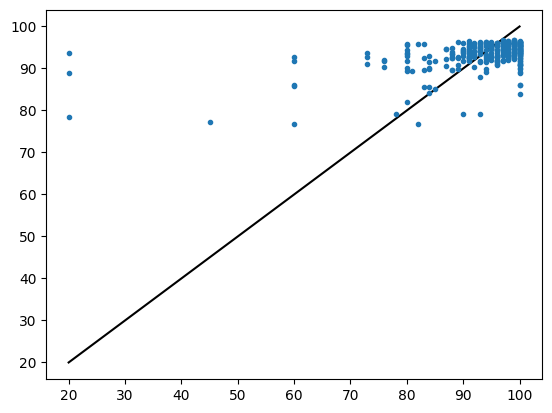

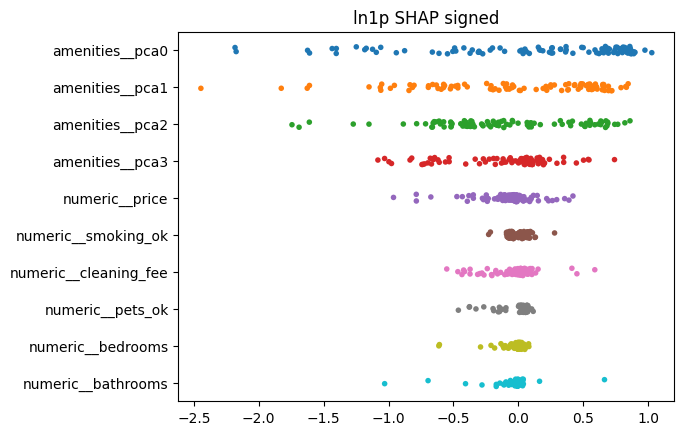

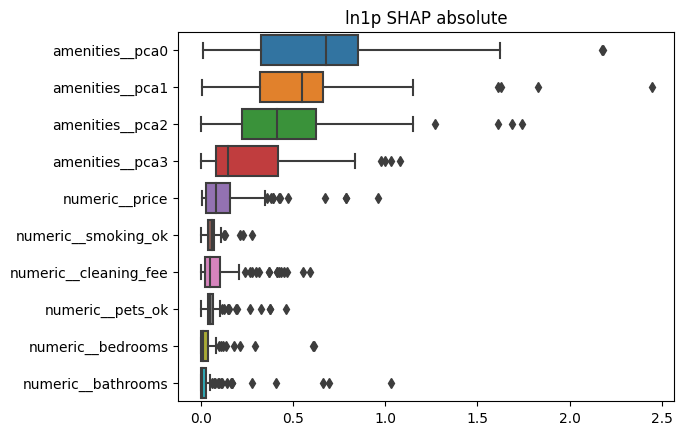

,count,mean,std,min,25%,50%,75%,max
amenities__pca0,100.0,0.665805,0.422521,0.012541,0.326240,0.676100,0.852883,2.182729
amenities__pca1,100.0,0.552488,0.383289,0.008377,0.320141,0.546909,0.661471,2.445762
amenities__pca2,100.0,0.460779,0.327180,0.001481,0.222381,0.411111,0.621954,1.743805
amenities__pca3,100.0,0.270114,0.275660,0.001454,0.083264,0.147123,0.415615,1.081798
numeric__price,100.0,0.140248,0.178320,0.004268,0.028304,0.079462,0.158871,0.961473
numeric__smoking_ok,100.0,0.059076,0.042230,0.000769,0.037011,0.058180,0.072406,0.279672
numeric__cleaning_fee,100.0,0.104170,0.134590,0.000461,0.021743,0.048592,0.104493,0.589592
numeric__pets_ok,100.0,0.069531,0.076536,0.001686,0.036407,0.046768,0.067552,0.461644
numeric__bedrooms,100.0,0.039071,0.094033,0.000014,0.001242,0.010217,0.037685,0.612163
numeric__bathrooms,100.0,0.051027,0.147278,0.000034,0.001546,0.006708,0.025189,1.029787


In [4]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
learner = RandomForestRegressor(random_state=seed)
hyperparameters = {
    'prep__combined__amenities__pca__n_components': [2,4],
    'prep__imputer__n_neighbors': [3,7],
    'learner__max_depth': [3,6,9],
}
model = run_model(learner, hyperparameters)
regessors[model.name] = model
shap_values = run_shap(model)

Fitting KNeighborsRegressor with hyperparameter grid: {'prep__combined__amenities__pca__n_components': [2, 4], 'prep__imputer__n_neighbors': [3, 7], 'learner__n_neighbors': [3, 6, 9]}
best model: R^2=0.184 with hyperparameters {'learner__n_neighbors': 9, 'prep__combined__amenities__pca__n_components': 4, 'prep__imputer__n_neighbors': 7}


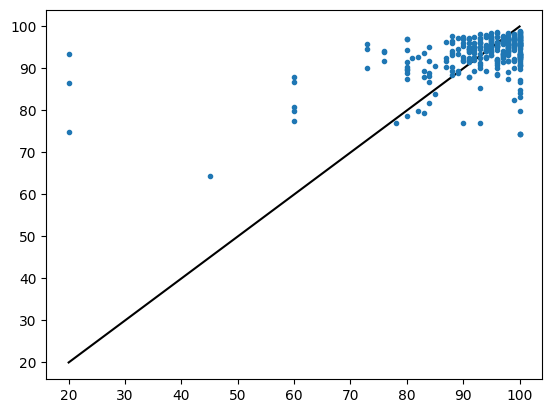

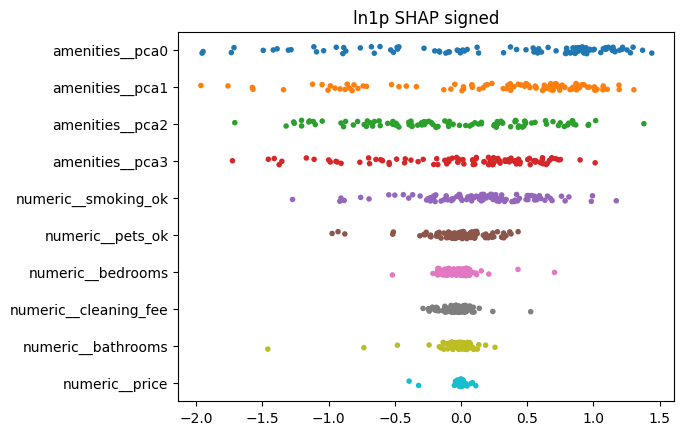

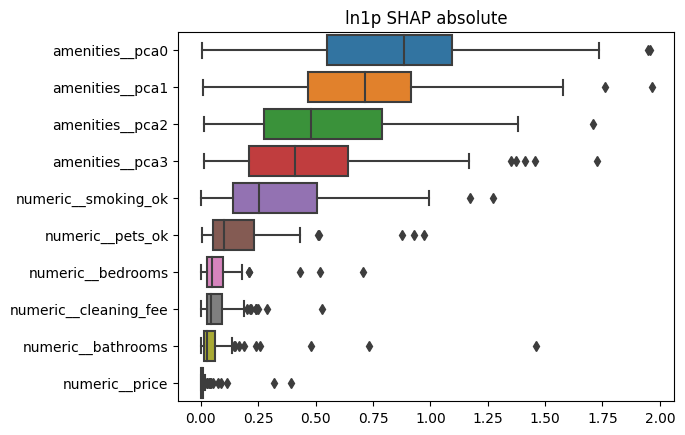

,count,mean,std,min,25%,50%,75%,max
amenities__pca0,100.0,0.828452,0.435067,0.005045,0.549612,0.885377,1.096123,1.956004
amenities__pca1,100.0,0.703079,0.380024,0.007726,0.464837,0.717222,0.914665,1.964962
amenities__pca2,100.0,0.551389,0.359727,0.011481,0.276418,0.480675,0.787119,1.708782
amenities__pca3,100.0,0.474117,0.356459,0.015045,0.208408,0.410108,0.642691,1.726692
numeric__smoking_ok,100.0,0.343885,0.279687,0.000903,0.139914,0.254145,0.506616,1.272640
numeric__pets_ok,100.0,0.163584,0.177270,0.003613,0.053109,0.101573,0.229744,0.973651
numeric__bedrooms,100.0,0.076636,0.100504,0.001014,0.025169,0.048322,0.094584,0.706434
numeric__cleaning_fee,100.0,0.074229,0.080139,0.000507,0.024993,0.044068,0.093576,0.526741
numeric__bathrooms,100.0,0.070369,0.169513,0.000824,0.013824,0.025140,0.062684,1.459481
numeric__price,100.0,0.017167,0.051983,0.000004,0.001584,0.004527,0.009789,0.391917


,amenities__pca0,amenities__pca1,amenities__pca2,amenities__pca3,numeric__smoking_ok,numeric__pets_ok,numeric__bedrooms,numeric__cleaning_fee,numeric__bathrooms,numeric__price
0,-1.566080,0.895088,-0.479189,-0.833986,-0.648933,0.035772,0.016071,-0.029087,0.031036,0.001530
1,1.491486,1.793876,-0.300732,0.279519,-0.006133,0.096618,0.012914,-0.047244,-0.017125,0.007932
2,1.329868,1.745335,-0.250432,0.336931,0.504907,-0.039334,0.018461,-0.205075,0.100551,-0.007879
3,1.564608,1.920401,0.508884,0.498272,1.259802,-0.003933,0.040970,-0.028884,0.004299,-0.008862
4,1.209409,1.533554,-0.599533,0.686667,0.532826,-0.099810,0.164987,0.025146,0.293148,0.009162
...,...,...,...,...,...,...,...,...,...,...
95,1.416195,0.263488,-0.208161,-0.201226,-0.215855,-0.181393,0.042760,-0.023774,-0.022460,-0.002906
96,1.220754,0.967650,0.166151,0.559444,-0.229039,-0.254907,-0.080996,-0.043188,-0.070498,-0.479815
97,1.422769,1.147694,1.088730,0.396389,0.521936,-0.098743,-0.196777,-0.015657,-0.071071,0.004731
98,0.735119,0.876437,-0.482897,0.321477,1.137509,-0.070154,0.039087,-0.072650,0.042399,0.007006


In [5]:
# K-nearest neighbors
from sklearn.neighbors import KNeighborsRegressor
learner = KNeighborsRegressor()
hyperparameters = {
    'prep__combined__amenities__pca__n_components': [2,4],
    'prep__imputer__n_neighbors': [3,7],
    'learner__n_neighbors': [3,6,9],
}
model = run_model(learner, hyperparameters)
regessors[model.name] = model
run_shap(model)

Fitting SVR with hyperparameter grid: {'prep__combined__amenities__pca__n_components': [2, 4], 'prep__imputer__n_neighbors': [3, 7], 'learner__C': array([0.1 , 2.55, 5.  ])}
best model: R^2=0.074 with hyperparameters {'learner__C': 5.0, 'prep__combined__amenities__pca__n_components': 4, 'prep__imputer__n_neighbors': 3}


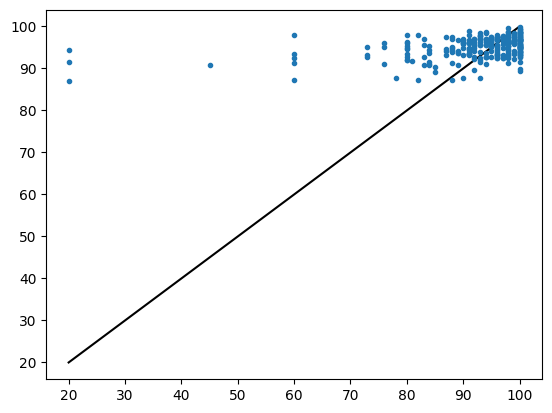

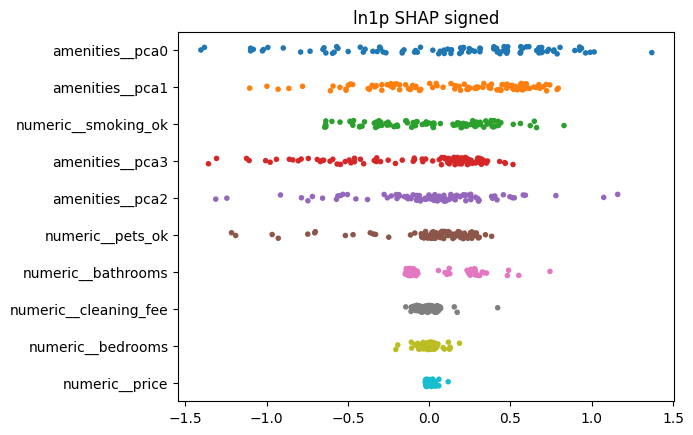

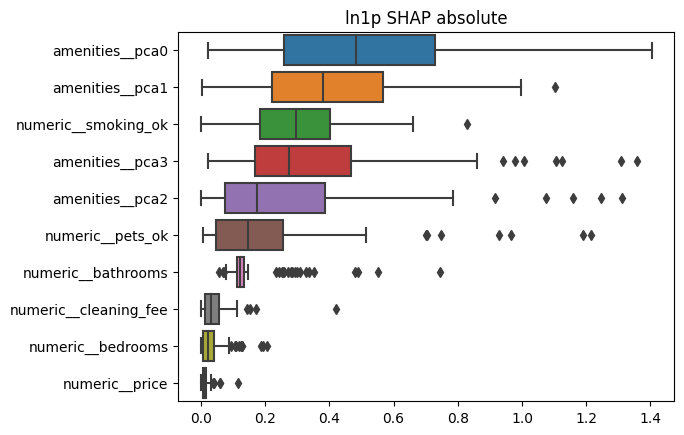

,count,mean,std,min,25%,50%,75%,max
amenities__pca0,100.0,0.524096,0.326680,0.022761,0.259046,0.482898,0.728261,1.404201
amenities__pca1,100.0,0.405110,0.235750,0.003330,0.220822,0.381198,0.566553,1.104225
numeric__smoking_ok,100.0,0.300078,0.180185,0.002047,0.184472,0.295062,0.402186,0.829628
amenities__pca3,100.0,0.361411,0.285939,0.021485,0.169122,0.276012,0.466138,1.357641
amenities__pca2,100.0,0.271680,0.282150,0.001601,0.076575,0.176086,0.385499,1.312815
numeric__pets_ok,100.0,0.202319,0.233340,0.005449,0.047985,0.146865,0.255846,1.215842
numeric__bathrooms,100.0,0.158470,0.107700,0.057319,0.111485,0.122809,0.135751,0.743234
numeric__cleaning_fee,100.0,0.042918,0.052075,0.000611,0.012094,0.031109,0.056524,0.421506
numeric__bedrooms,100.0,0.035859,0.042062,0.000211,0.007879,0.021714,0.041889,0.204990
numeric__price,100.0,0.014990,0.014611,0.000464,0.007338,0.013678,0.017501,0.117179


,amenities__pca0,amenities__pca1,numeric__smoking_ok,amenities__pca3,amenities__pca2,numeric__pets_ok,numeric__bathrooms,numeric__cleaning_fee,numeric__bedrooms,numeric__price
0,0.023022,1.212710,-0.534928,0.136057,0.468200,0.022324,-0.105297,0.002048,0.011615,-0.017502
1,0.060771,0.574279,-0.217468,-0.179684,2.190149,0.469036,0.114846,0.022005,0.006805,-0.011434
2,0.819463,0.826316,0.307059,0.078510,0.211216,0.034403,-0.127872,-0.061534,0.023108,-0.015865
3,0.520058,0.400028,0.369366,0.265728,0.497553,0.048813,0.058993,-0.057858,0.005508,-0.011547
4,0.231329,0.769287,-0.510292,0.269234,-0.261497,0.242908,0.735966,0.073629,-0.010455,0.033286
...,...,...,...,...,...,...,...,...,...,...
95,1.618142,0.855058,0.677914,0.190483,-0.652997,0.084370,-0.107380,0.014293,0.010940,0.018898
96,0.219936,-0.668087,-0.888490,-0.583100,-0.075565,0.121003,-0.111965,-0.002323,0.036742,0.011783
97,0.752656,0.709966,-0.149997,0.183991,0.579084,0.012617,0.630675,0.070892,-0.115989,0.061390
98,0.275986,1.054514,0.454706,0.333173,-0.293066,0.088424,-0.071701,-0.047807,0.005116,-0.016175


In [6]:
# Support Vector Machines
from sklearn.svm import SVR
learner = SVR()
hyperparameters = {
    'prep__combined__amenities__pca__n_components': [2,4],
    'prep__imputer__n_neighbors': [3,7],
    'learner__C': np.linspace(0.1,5,3),
}
model = run_model(learner, hyperparameters)
regessors[model.name] = model
run_shap(model)

Well, these models suck. R^2 ranges from 0 (terrible) to 1 (perfect). Even our best model is less than 0.2.  So, we want to go back and rethink some choices made along the way. But we built this code so that will probably not require much effort or recoding.

#Classification

Now, let's bin the target and demonstrate a classification task

In [7]:
# In order to make this a classification task, we will use pandas qcut function to bin the target values into n_labels classes with roughly equal frequencies
y = df.loc[mask, target]
n_labels = 2
y_binned = pd.qcut(df.loc[mask, target], q=n_labels, precision=1)
y    = y_binned.cat.codes
bins = y_binned.cat.categories.astype(str).to_list()

# create holdout set to estimate generalization performance after tuning
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.10, random_state=seed)

# dictionary to store models
classifiers = dict()

# function to make training with different supervised learners convenient
def run_model(learner, hyperparameters):
    # append final learner to pipeline
    estimator = Pipeline(steps = [('prep', prep), ('learner', learner)])
    
    # prepare to tune hyperparameters using either exhaustive grid search or randomized grid search
    model =       GridSearchCV(estimator, hyperparameters, cv=5, scoring='f1_micro')
    # model = RandomizedSearchCV(estimator, hyperparameters, cv=5, scoring='f1_micro')
    
    # give model a name based on its learner
    model.name = str(learner).split('(')[0]

    print(f'Fitting {model.name} with hyperparameter grid:', hyperparameters)
    model.fit(X_train, y_train)

    # Apply best model to holdout set to estimate generalization performance
    model.generalization_score = model.score(X_holdout, y_holdout)
    print(f'best model: F1={model.generalization_score:.3f} with hyperparameters {model.best_params_}')
    print(classification_report(y_holdout, model.predict(X_holdout), target_names=bins))
    
    ConfusionMatrixDisplay.from_estimator(model, X_holdout, y_holdout, display_labels=bins)
    plt.show()
    
    if n_labels == 2:
        RocCurveDisplay.from_estimator(model, X_holdout, y_holdout)
        plt.plot([0,1],[0,1])
        plt.show()

    # save file to google drive folder
    file = path / f'{model.name}.model'
    model.file = file
    joblib.dump(model, file)
    return model

Fitting RandomForestClassifier with hyperparameter grid: {'prep__combined__amenities__pca__n_components': [2, 4], 'prep__imputer__n_neighbors': [3, 7], 'learner__max_depth': [3, 6, 9]}
best model: F1=0.635 with hyperparameters {'learner__max_depth': 9, 'prep__combined__amenities__pca__n_components': 4, 'prep__imputer__n_neighbors': 7}
               precision    recall  f1-score   support

 (19.9, 96.0]       0.64      0.75      0.69       162
(96.0, 100.0]       0.63      0.50      0.56       139

     accuracy                           0.63       301
    macro avg       0.63      0.62      0.62       301
 weighted avg       0.63      0.63      0.63       301



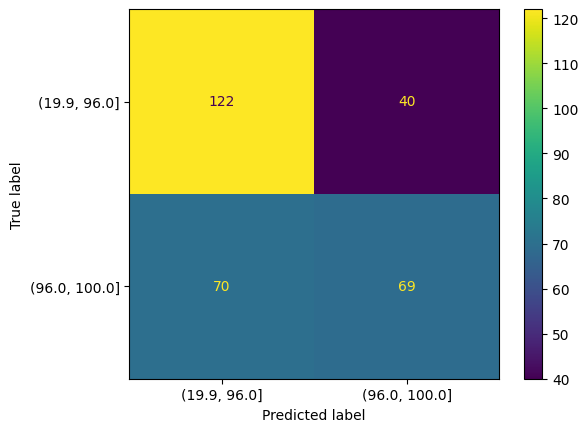

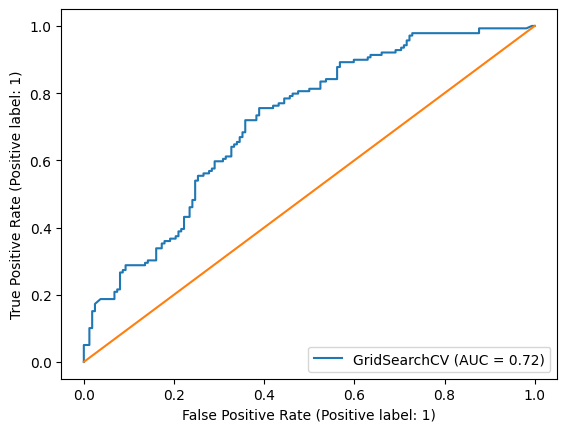

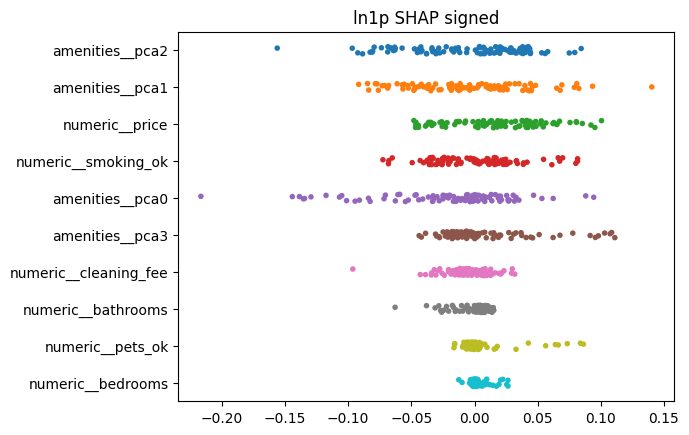

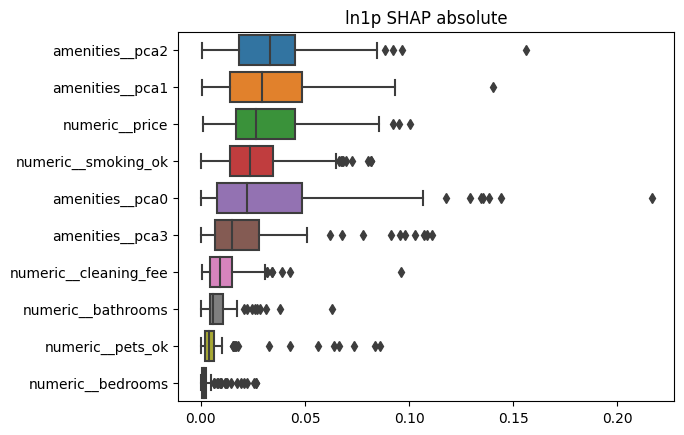

,count,mean,std,min,25%,50%,75%,max
amenities__pca2,100.0,0.037553,0.026238,0.000700,0.018430,0.033351,0.045082,0.156197
amenities__pca1,100.0,0.035663,0.026798,0.000438,0.013836,0.029442,0.048510,0.140378
numeric__price,100.0,0.032932,0.022262,0.000901,0.016699,0.026670,0.045033,0.100577
numeric__smoking_ok,100.0,0.026965,0.019537,0.000220,0.014010,0.023749,0.034549,0.081618
amenities__pca0,100.0,0.036997,0.040975,0.000200,0.007562,0.022342,0.048418,0.216630
amenities__pca3,100.0,0.023332,0.026375,0.000075,0.006734,0.015170,0.027822,0.111099
numeric__cleaning_fee,100.0,0.012599,0.012667,0.000356,0.004485,0.009186,0.015020,0.096355
numeric__bathrooms,100.0,0.008858,0.008915,0.000023,0.004231,0.006006,0.010522,0.062880
numeric__pets_ok,100.0,0.008989,0.017240,0.000016,0.001776,0.003710,0.006124,0.086257
numeric__bedrooms,100.0,0.003743,0.006045,0.000027,0.000512,0.001483,0.002601,0.026532


,amenities__pca2,amenities__pca1,numeric__price,numeric__smoking_ok,amenities__pca0,amenities__pca3,numeric__cleaning_fee,numeric__bathrooms,numeric__pets_ok,numeric__bedrooms
0,-0.058999,-0.071117,0.054276,0.016889,0.000798,-0.010519,-0.003617,0.002391,-0.002515,0.000238
1,-0.096803,-0.011424,-0.047511,0.000220,-0.014815,-0.023372,-0.043879,-0.027170,-0.000526,0.000418
2,-0.043336,-0.036979,0.035620,-0.033388,-0.033639,-0.017604,0.003844,0.001272,-0.002752,-0.000906
3,-0.038658,-0.096055,0.018079,-0.029420,-0.037156,-0.015210,-0.020835,0.002405,-0.002505,0.002463
4,0.020287,-0.054273,-0.045336,0.019946,0.002864,-0.013790,-0.014360,-0.064899,-0.003589,0.003507
...,...,...,...,...,...,...,...,...,...,...
95,-0.071158,-0.018535,-0.012456,-0.041125,-0.001626,-0.011970,-0.009903,0.001829,0.002956,-0.002023
96,0.032718,0.012348,-0.047815,0.063150,-0.028291,0.069990,0.000649,0.007199,0.008188,0.000418
97,-0.083950,-0.006061,-0.049193,0.010087,-0.062544,-0.000705,-0.020739,-0.014628,-0.000216,-0.003879
98,0.041162,-0.063160,0.064096,-0.036376,-0.003532,-0.022288,-0.017293,0.003986,-0.001700,-0.001940


In [8]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
learner = RandomForestClassifier(random_state=seed)
hyperparameters = {
    'prep__combined__amenities__pca__n_components': [2,4],
    'prep__imputer__n_neighbors': [3,7],
    'learner__max_depth': [3,6,9],
}
model = run_model(learner, hyperparameters)
classifiers[model.name] = model
run_shap(model)

Fitting KNeighborsClassifier with hyperparameter grid: {'prep__combined__amenities__pca__n_components': [2, 4], 'prep__imputer__n_neighbors': [3, 7], 'learner__n_neighbors': [3, 6, 9]}
best model: F1=0.635 with hyperparameters {'learner__n_neighbors': 9, 'prep__combined__amenities__pca__n_components': 4, 'prep__imputer__n_neighbors': 3}
               precision    recall  f1-score   support

 (19.9, 96.0]       0.64      0.72      0.68       162
(96.0, 100.0]       0.62      0.54      0.58       139

     accuracy                           0.63       301
    macro avg       0.63      0.63      0.63       301
 weighted avg       0.63      0.63      0.63       301



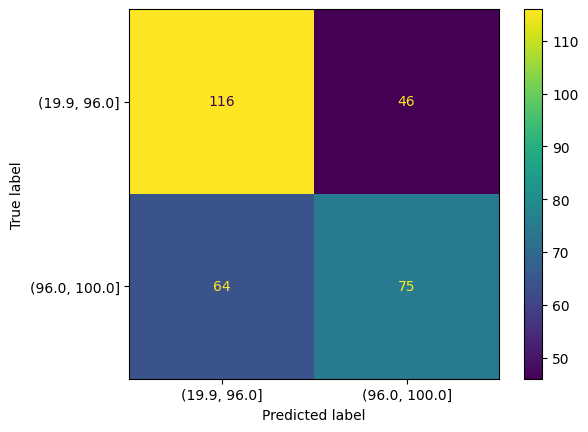

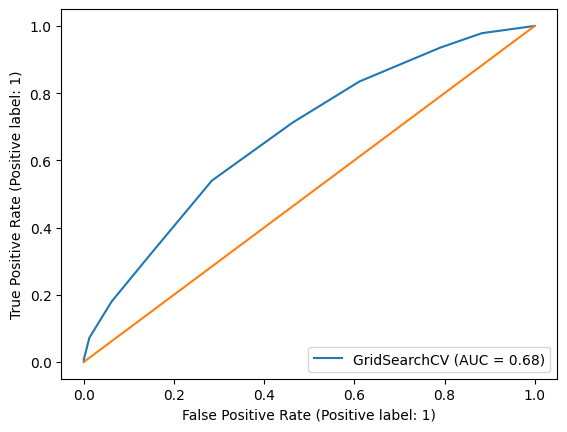

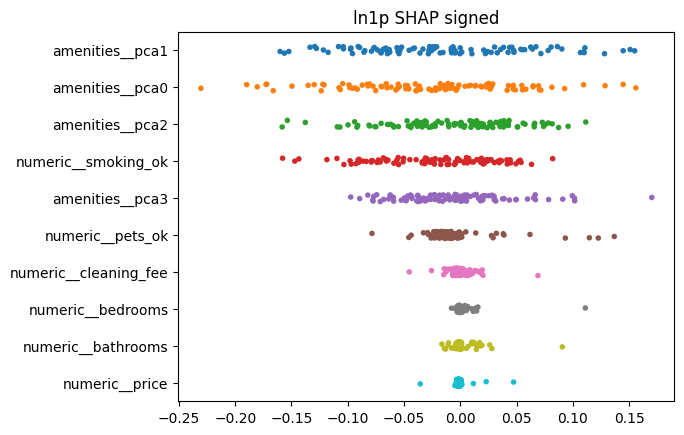

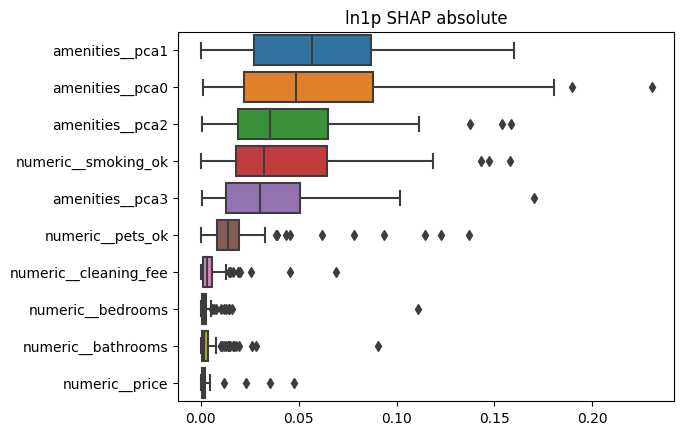

,count,mean,std,min,25%,50%,75%,max
amenities__pca1,100.0,0.061916,0.041432,0.000062,0.027152,0.056741,0.087077,0.160082
amenities__pca0,100.0,0.062033,0.049611,0.001256,0.021886,0.048752,0.088210,0.230454
amenities__pca2,100.0,0.043699,0.034033,0.000463,0.018742,0.035496,0.064880,0.158284
numeric__smoking_ok,100.0,0.043190,0.034505,0.000269,0.018176,0.032399,0.064600,0.157870
amenities__pca3,100.0,0.036470,0.030317,0.000441,0.012991,0.030218,0.050436,0.170174
numeric__pets_ok,100.0,0.019714,0.023533,0.000269,0.008403,0.013998,0.019362,0.136825
numeric__cleaning_fee,100.0,0.005600,0.009102,0.000009,0.001169,0.002956,0.005858,0.069005
numeric__bedrooms,100.0,0.003530,0.011302,0.000097,0.000816,0.001564,0.002676,0.111122
numeric__bathrooms,100.0,0.004715,0.010390,0.000018,0.000685,0.001430,0.003701,0.090666
numeric__price,100.0,0.002573,0.006206,0.000013,0.000673,0.001401,0.002328,0.047408


,amenities__pca1,amenities__pca0,amenities__pca2,numeric__smoking_ok,amenities__pca3,numeric__pets_ok,numeric__cleaning_fee,numeric__bedrooms,numeric__bathrooms,numeric__price
0,-0.033717,0.115767,0.051980,0.054683,0.061561,-0.008183,-0.002769,-0.002729,-0.001843,-0.001415
1,-0.082112,-0.112443,-0.056504,-0.011715,-0.038541,-0.016235,-0.003166,-0.001609,0.001063,-0.000961
2,-0.015467,-0.067989,0.002941,-0.045833,0.020212,-0.000979,0.012954,0.000168,-0.003748,-0.002257
3,-0.068316,-0.197676,-0.084436,-0.070802,0.001464,-0.008990,-0.001160,-0.001146,0.000388,-0.002659
4,-0.102385,-0.022152,0.003474,0.020198,-0.003567,-0.009616,0.016777,0.003122,-0.002597,-0.003254
...,...,...,...,...,...,...,...,...,...,...
95,-0.068884,-0.055617,0.014660,-0.068197,-0.019140,-0.007187,-0.001980,-0.002641,-0.000728,-0.001398
96,0.022632,0.023598,0.011468,0.044868,-0.050728,-0.005185,0.006543,0.010207,0.010269,0.048549
97,-0.124612,-0.097716,-0.096129,0.011839,0.006036,-0.000750,-0.009175,0.000710,-0.010741,-0.001684
98,-0.007981,-0.049524,0.040538,-0.115802,-0.064347,-0.007676,-0.001173,-0.000600,-0.003611,-0.000935


In [9]:
# K-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
learner = KNeighborsClassifier()
hyperparameters = {
    'prep__combined__amenities__pca__n_components': [2,4],
    'prep__imputer__n_neighbors': [3,7],
    'learner__n_neighbors': [3,6,9],
}
model = run_model(learner, hyperparameters)
classifiers[model.name] = model
run_shap(model)

Fitting SVC with hyperparameter grid: {'prep__combined__amenities__pca__n_components': [2, 4], 'prep__imputer__n_neighbors': [3, 7], 'learner__C': array([0.1 , 2.55, 5.  ])}
best model: F1=0.618 with hyperparameters {'learner__C': 5.0, 'prep__combined__amenities__pca__n_components': 4, 'prep__imputer__n_neighbors': 3}
               precision    recall  f1-score   support

 (19.9, 96.0]       0.62      0.73      0.67       162
(96.0, 100.0]       0.61      0.48      0.54       139

     accuracy                           0.62       301
    macro avg       0.62      0.61      0.61       301
 weighted avg       0.62      0.62      0.61       301



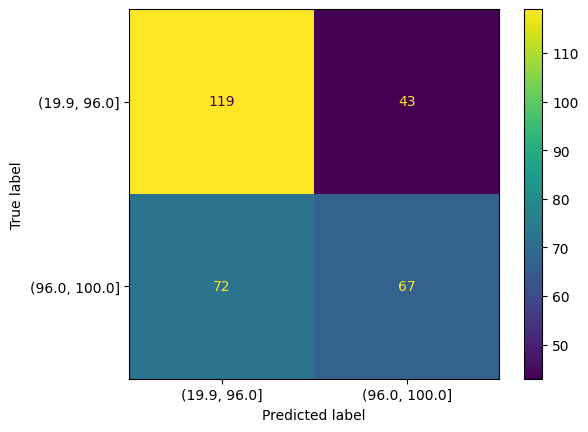

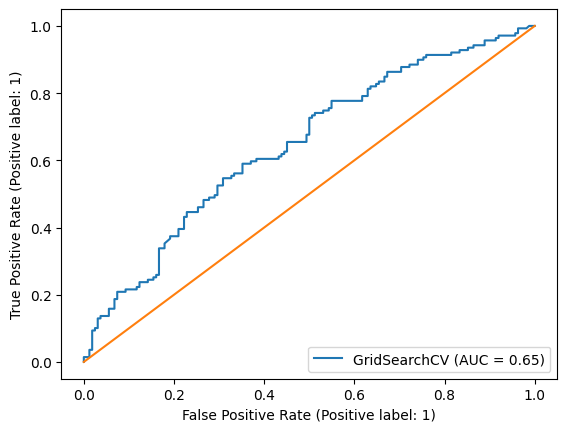

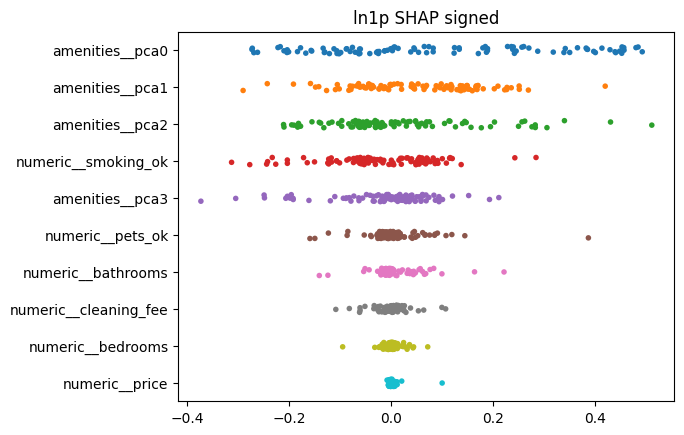

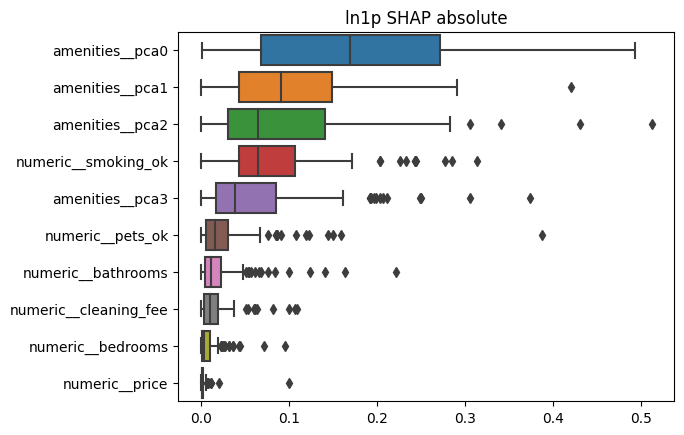

,count,mean,std,min,25%,50%,75%,max
amenities__pca0,100.0,0.189480,0.144191,7.140307e-04,0.068546,0.169373,0.270996,0.493074
amenities__pca1,100.0,0.103837,0.077435,3.968175e-05,0.043533,0.091240,0.148762,0.420354
amenities__pca2,100.0,0.099032,0.095565,5.157400e-04,0.031185,0.064483,0.140374,0.511825
numeric__smoking_ok,100.0,0.082548,0.066531,4.760771e-04,0.043598,0.064278,0.106904,0.313187
amenities__pca3,100.0,0.065757,0.072146,3.570791e-04,0.017271,0.038629,0.084738,0.373423
numeric__pets_ok,100.0,0.031681,0.050111,3.968175e-05,0.005747,0.015533,0.030674,0.387339
numeric__bathrooms,100.0,0.024072,0.035733,2.380669e-04,0.004958,0.010971,0.023267,0.221714
numeric__cleaning_fee,100.0,0.017026,0.022254,2.777392e-04,0.003614,0.009852,0.019773,0.108534
numeric__bedrooms,100.0,0.009391,0.014603,3.968175e-05,0.001675,0.003921,0.009793,0.095094
numeric__price,100.0,0.003336,0.010203,3.469447e-18,0.000783,0.001626,0.002784,0.100240


,amenities__pca0,amenities__pca1,amenities__pca2,numeric__smoking_ok,amenities__pca3,numeric__pets_ok,numeric__bathrooms,numeric__cleaning_fee,numeric__bedrooms,numeric__price
0,-0.012460,0.183810,0.215476,-0.319841,-0.082024,-0.172778,0.002421,0.004484,-0.015040,-0.004048
1,0.203135,0.020000,0.668333,-0.045556,-0.016190,-0.024087,0.004643,-0.005952,-0.001944,-0.002381
2,0.420000,0.153730,0.122460,0.072579,0.035079,-0.001627,-0.000635,-0.000357,-0.000516,-0.000714
3,0.256865,0.146706,0.284206,0.123016,0.021190,-0.015913,0.009325,-0.021310,-0.002897,-0.001190
4,-0.140119,0.145556,-0.148333,-0.274444,-0.036190,-0.014603,0.177976,0.055079,0.023532,0.011548
...,...,...,...,...,...,...,...,...,...,...
95,0.039325,0.522500,0.061865,0.114603,0.060437,-0.003849,-0.011825,0.012540,0.001587,0.002817
96,0.002619,-0.040794,-0.064802,-0.112857,0.017460,0.003056,-0.000873,-0.002143,-0.002738,0.001071
97,0.403929,0.124802,0.158929,-0.050913,0.041032,-0.015833,0.067579,0.026429,0.036587,0.007460
98,0.086190,0.143254,-0.234008,0.086190,-0.013571,-0.161468,0.005079,-0.085476,-0.022937,-0.003254


In [10]:
# Support Vector Machines
from sklearn.svm import SVC
learner = SVC()
hyperparameters = {
    'prep__combined__amenities__pca__n_components': [2,4],
    'prep__imputer__n_neighbors': [3,7],
    'learner__C': np.linspace(0.1,5,3),
}
model = run_model(learner, hyperparameters)
classifiers[model.name] = model
run_shap(model)